In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
47113,NaN,NaN,International,2020-09-28,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47114,NaN,NaN,International,2020-09-29,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47115,NaN,NaN,International,2020-09-30,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


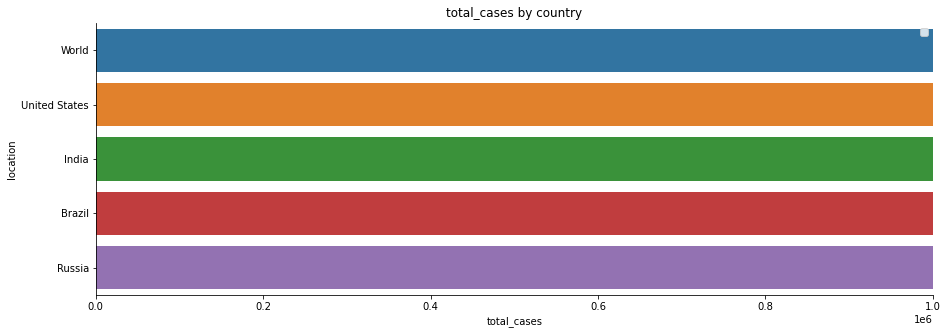

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


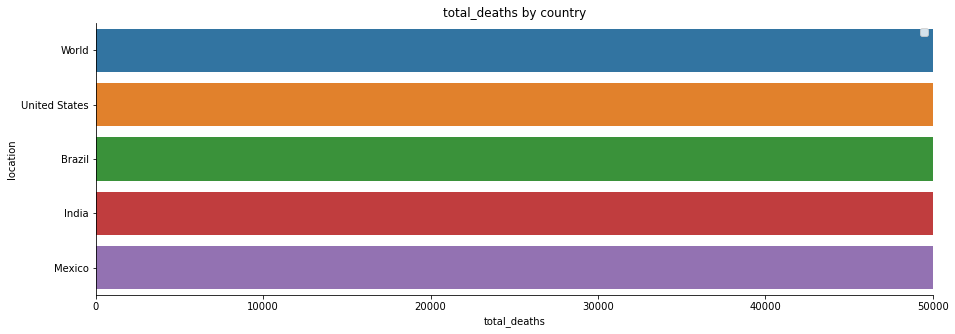

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


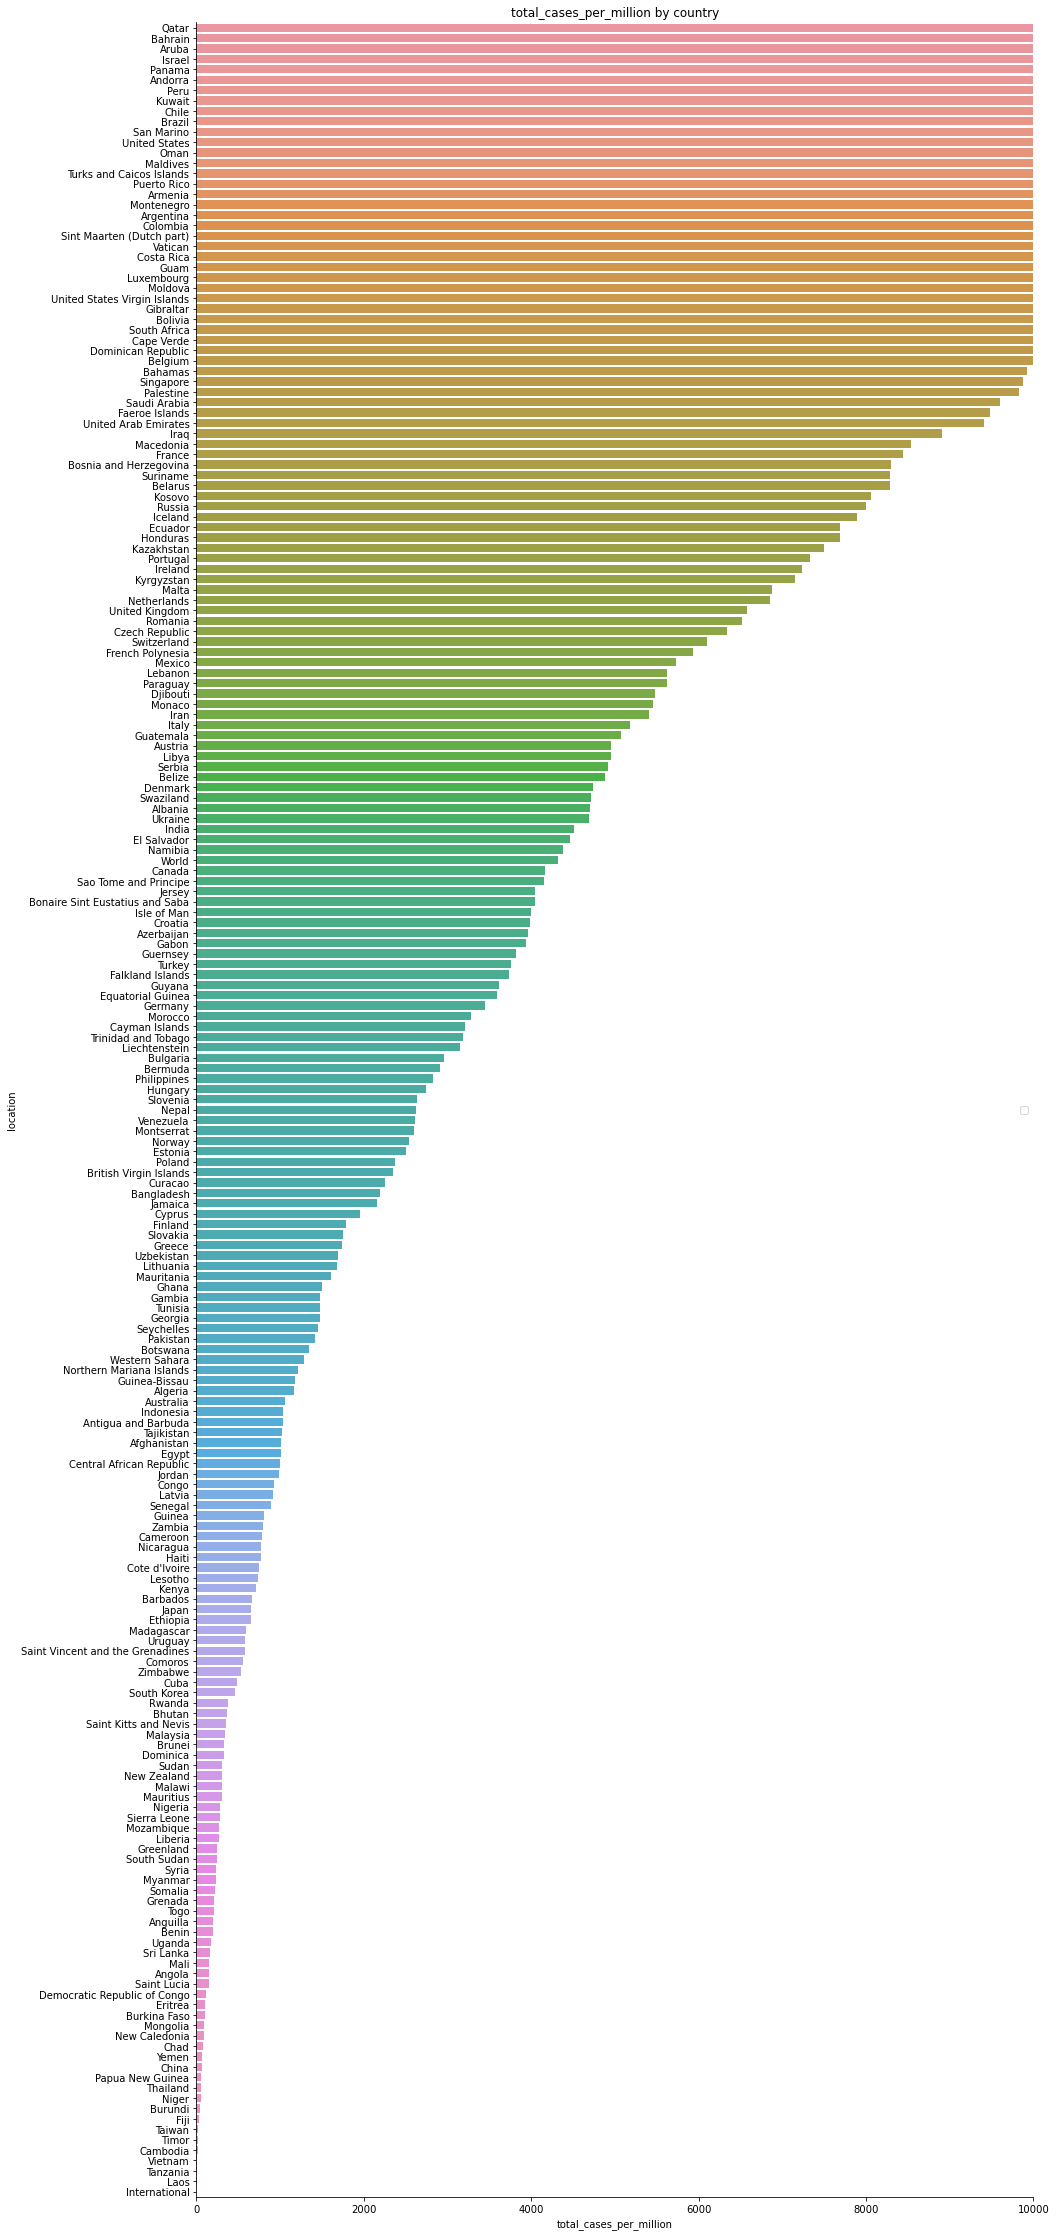

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


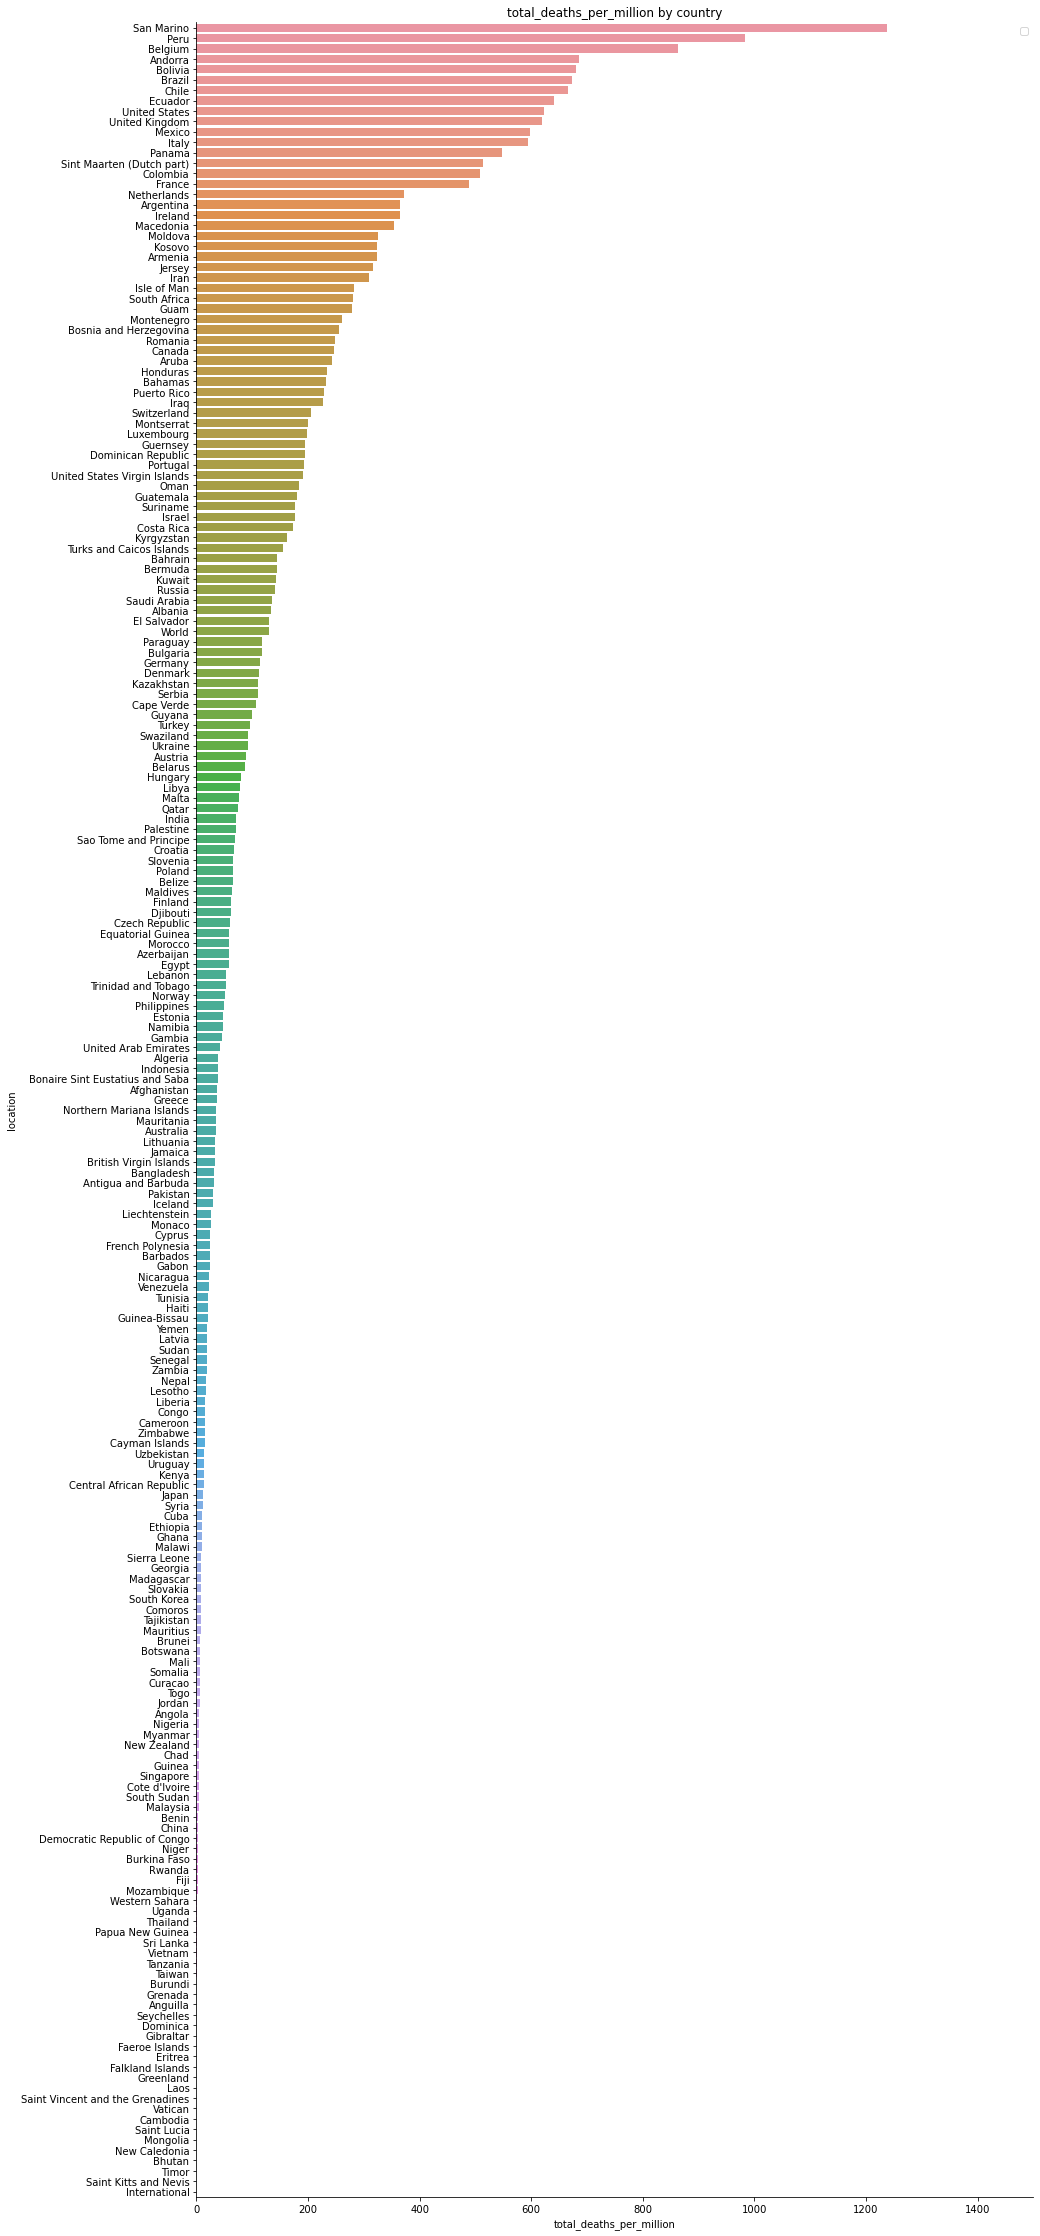

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

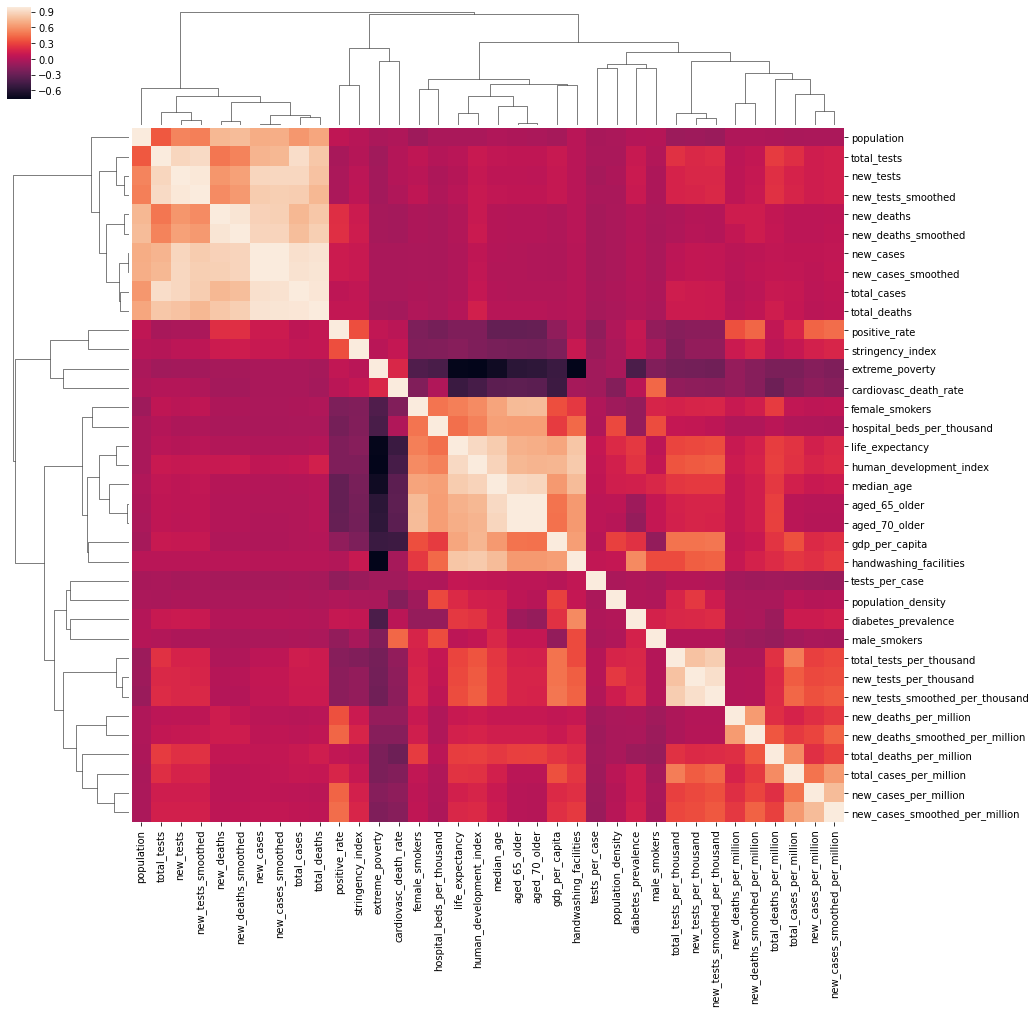

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9982930268372722 (+/- 0.0022611227227303833)
Coef :  [1.02999038e+00 7.72656055e-05 8.07798943e-05]
3 Last_days :  [[33202820 33436665 33714595]]
Today :  33714595
Prediction + :  600447
Tomorow :  34315042
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995872442205834 (+/- 0.00022620055102262355)
Coef :  [0.26534112 0.36144515 0.38298423]
3 Last_days :  [[ 998983 1002905 1008932]]
Today :  1008932
Prediction + :  8598
Tomorow :  1017530
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.05038606048042401 (+/- 1.48168889883405)
Coef :  [-0.69654832  0.74090243  0.96176059]
3 Last_days :  [[538569 542639 550690]]
Today :  550690
Prediction + :  5766
Tomorow :  556456
                                     
--------- Total Death -----------------
                                     
R^2: 0.7329865166747291 (+/- 0.37072169301889507)
Coef :  [-0.74344063  0.78689813  0.95551369]
3 Last_days :  [[31727 31808 31893]]
Today :  31893
Prediction + :  78
Tomorow :  31971
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9689592191096036 (+/- 0.034412957428638535)
Coef :  [-0.33159888 -0.00735888  1.33322311]
3 Last_days :  [[90483 90505 90528]]
Today :  90528
Prediction + :  23
Tomorow :  90551
                                     
--------- Total Death -----------------
                                     
R^2: -16.39461908642356 (+/- 24.498603028446784)
Coef :  [-0.07782817  0.01249769  1.05697636]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  5
Tomorow :  4744
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9198124514232249 (+/- 0.11224920722474827)
Coef :  [-0.80461999  0.88932037  0.91481676]
3 Last_days :  [[309870 311364 313011]]
Today :  313011
Prediction + :  1320
Tomorow :  314331
                                     
--------- Total Death -----------------
                                     
R^2: -0.29095130935092445 (+/- 1.8084371431226296)
Coef :  [-0.81678166  0.89385657  0.92189273]
3 Last_days :  [[35835 35851 35875]]
Today :  35875
Prediction + :  31
Tomorow :  35906
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: -3.4049310660600356 (+/- 6.219177235182082)
Coef :  [-0.20433167  0.13851407  1.07599635]
3 Last_days :  [[716481 748266 758172]]
Today :  758172
Prediction + :  14809
Tomorow :  772981
                                     
--------- Total Death -----------------
                                     
R^2: -0.8059096496778978 (+/- 2.2684688603093446)
Coef :  [-0.73032286  0.64637761  1.08305269]
3 Last_days :  [[31232 31411 31614]]
Today :  31614
Prediction + :  158
Tomorow :  31772
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9233798663703089 (+/- 0.10489216949927453)
Coef :  [0.18220533 0.41129526 0.41875945]
3 Last_days :  [[7115046 7148044 7191061]]
Today :  7191061
Prediction + :  76689
Tomorow :  7267750
                                     
--------- Total Death -----------------
                                     
R^2: 0.9791241385641665 (+/- 0.028245732124459952)
Coef :  [-0.35169546  0.64715352  0.70725605]
3 Last_days :  [[204756 205070 205998]]
Today :  205998
Prediction + :  889
Tomorow :  206887
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9951551381355616 (+/- 0.005957234846944714)
Coef :  [-0.70947913  0.84521251  0.86578678]
3 Last_days :  [[434969 439013 446156]]
Today :  446156
Prediction + :  3034
Tomorow :  449190
                                     
--------- Total Death -----------------
                                     
R^2: 0.20973589854646194 (+/- 1.0913712085703995)
Coef :  [-0.76085233  0.82887916  0.93118635]
3 Last_days :  [[41988 42001 42072]]
Today :  42072
Prediction + :  38
Tomorow :  42110
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.679576973556817 (+/- 0.4523165360687999)
Coef :  [-0.7655735   0.84320273  0.92247551]
3 Last_days :  [[285332 287421 289219]]
Today :  289219
Prediction + :  1818
Tomorow :  291037
                                     
--------- Total Death -----------------
                                     
R^2: 0.20958973735739986 (+/- 1.1099912176502074)
Coef :  [-0.7803303   0.83771682  0.94179727]
3 Last_days :  [[9460 9471 9488]]
Today :  9488
Prediction + :  13
Tomorow :  9501
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9990091715954771 (+/- 0.0009165442024654469)
Coef :  [0.40742631 0.30419074 0.30009751]
3 Last_days :  [[446448 449960 453637]]
Today :  453637
Prediction + :  2945
Tomorow :  456582
                                     
--------- Total Death -----------------
                                     
R^2: 0.9147029386516056 (+/- 0.11974032469081626)
Coef :  [0.23004154 0.3972331  0.38436091]
3 Last_days :  [[25589 25779 25986]]
Today :  25986
Prediction + :  204
Tomorow :  26190
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996310125315006 (+/- 0.0002635110088019719)
Coef :  [-0.57877408  0.77615239  0.79999038]
3 Last_days :  [[314433 315845 317272]]
Today :  317272
Prediction + :  1161
Tomorow :  318433
                                     
--------- Total Death -----------------
                                     
R^2: 0.9992512400051629 (+/- 0.0006906653493842809)
Coef :  [-0.81679547  0.89781002  0.91761836]
3 Last_days :  [[7997 8062 8130]]
Today :  8130
Prediction + :  53
Tomorow :  8183
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.947357822436023 (+/- 0.06958673486767715)
Coef :  [-0.11422251  0.5102503   0.61494466]
3 Last_days :  [[4732309 4745464 4777522]]
Today :  4777522
Prediction + :  50595
Tomorow :  4828117
                                     
--------- Total Death -----------------
                                     
R^2: 0.4560727236945517 (+/- 0.7616868638994951)
Coef :  [-0.00682901  0.47530305  0.54107863]
3 Last_days :  [[141741 142058 142921]]
Today :  142921
Prediction + :  1330
Tomorow :  144251
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(33714595, 1008932, 34315042, 1017530),
 (550690, 31893, 556456, 31971),
 (313011, 35875, 314331, 35906),
 (758172, 31614, 772981, 31772),
 (7191061, 205998, 7267750, 206887),
 (90528, 4739, 90551, 4744),
 (446156, 42072, 449190, 42110),
 (289219, 9488, 291037, 9501),
 (453637, 25986, 456582, 26190),
 (317272, 8130, 318433, 8183),
 (4777522, 142921, 4828117, 144251)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-30,France,556456.0,0.0,31971.0,0.0,0.0,0.0
0,2020-09-30,China,90551.0,0.0,4744.0,0.0,0.0,0.0
0,2020-09-30,Italy,314331.0,0.0,35906.0,0.0,0.0,0.0
0,2020-09-30,Spain,772981.0,0.0,31772.0,0.0,0.0,0.0
0,2020-09-30,United States,7267750.0,0.0,206887.0,0.0,0.0,0.0
0,2020-09-30,World,34315042.0,0.0,1017530.0,0.0,0.0,0.0
0,2020-09-30,United Kingdom,449190.0,0.0,42110.0,0.0,0.0,0.0
0,2020-09-30,Germany,291037.0,0.0,9501.0,0.0,0.0,0.0
0,2020-09-30,Iran,456582.0,0.0,26190.0,0.0,0.0,0.0
0,2020-09-30,Turkey,318433.0,0.0,8183.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")